In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras import activations
from tqdm import tqdm
import cv2
import os
import scipy
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [2]:
#validation = list(range(1,31))
#validation= range(31,61)
validation = range(61,91)
#validation = range(91,121)

In [3]:
print(len(validation))

30


In [4]:
# Load X&Y & RESIZE & Normalize
X_DIR = '/kaggle/input/rips-orignial'
Y_DIR = '/kaggle/input/rips-dataset/G1'
def create_data():
    X=[]
    Y=[]
    Images_test = []
    Masks_test = []
    X_validation = []
    Y_validation =[]
    test_ex = [18, 47, 78, 120]
    for i in range(1,121):
        X_path= str(i)+'.jpg'
        Y_path=str(i)+'.png'
        X_path = os.path.join(X_DIR, X_path)
        Y_path = os.path.join(Y_DIR, Y_path)
        image = cv2.imread(X_path)
        mask = cv2.imread(Y_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (400, 300))
        mask = cv2.resize(mask, (400, 300))
        mask = np.where(mask>0, 255, 0)
        if i in test_ex:
            Images_test.append(image)
            Masks_test.append(mask)
        elif i in validation:
            X_validation.append(image)
            Y_validation.append(mask)
        else:
            X.append(image)
            Y.append(mask)
    X = np.array(X).reshape(-1,300,400,3)
    Y = np.array(Y).reshape(-1,300,400)
    Images_test = np.array(Images_test).reshape(-1, 300, 400,3)
    Masks_test = np.array(Masks_test).reshape(-1, 300, 400)
    X_validation = np.array(X_validation).reshape(-1, 300, 400,3)
    Y_validation = np.array(Y_validation).reshape(-1, 300, 400)
    return X,Y, X_validation,Y_validation, Images_test, Masks_test

# Images = np.load('X_data.npy', allow_pickle=True)
# masks = np.load('Y_data.npy', allow_pickle=True)

In [5]:
X_train, Y_train, X_validation , Y_validation, Images_test, Masks_test = create_data()
print(X_train.shape)
print(Y_train.shape)
print(X_validation.shape)
print(Y_validation.shape)
print(Images_test.shape)
print(Masks_test.shape)

(87, 300, 400, 3)
(87, 300, 400)
(29, 300, 400, 3)
(29, 300, 400)
(4, 300, 400, 3)
(4, 300, 400)


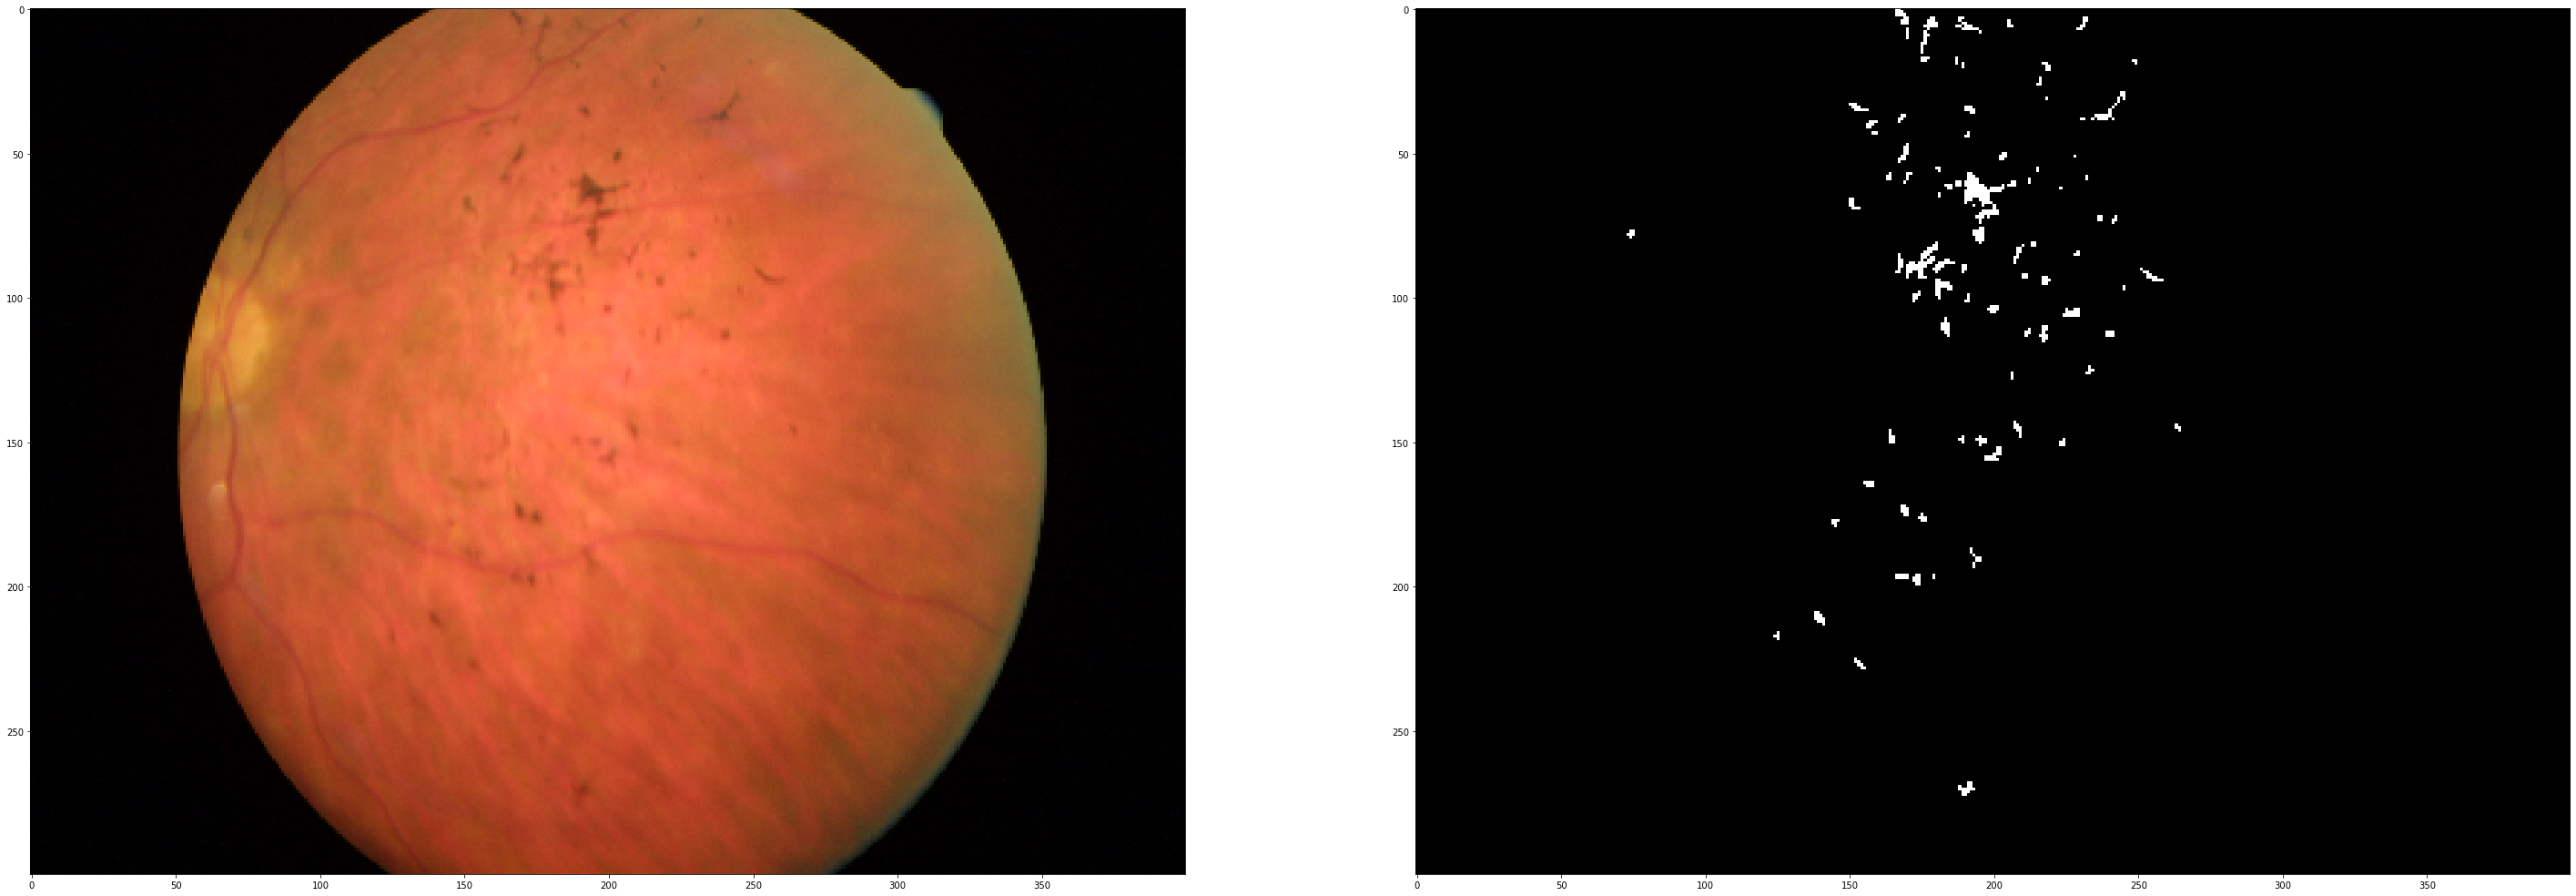

In [6]:
plt.figure(figsize=(50,50))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(Images_test[2,:,:,:], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(Masks_test[2,:,:])


In [7]:
print(np.unique(Y_train[60,:,:], return_counts=True))

(array([  0, 255]), array([119563,    437]))


In [8]:
def visualize(img, mask):
    plt.figure(figsize=(50,50))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(mask)

In [9]:
# IMAGES AUGMENTATION
#--------------------
def flip (img_arr, flag, depth):
    flipped=[]
    n = img_arr.shape[0]
    for i in range(n):
        if depth==3:
            img = img_arr[i,:,:,:]
        else:
            img = img_arr[i,:,:]
        flipped.append(cv2.flip(img, flag))
    if depth==3:
        flipped = np.array(flipped).reshape(-1, 300, 400,3)
    else:
        flipped = np.array(flipped).reshape(-1, 300, 400)
    return flipped


In [10]:
#Augmentation (train only)
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
def augment(train, depth):
    temp1 = flip(train, 1, depth) 
    temp2 = flip(train, 0, depth)
    train = np.concatenate((train, temp1, temp2))
    print(train.shape)

    temp1 = np.roll(train, 50, axis=1) # 1 for x-axis, 2 for y-axis
    temp1 = np.roll(temp1, -50, axis=2)
    train = np.concatenate((train, temp1))
    print(train.shape)


    temp1 = np.roll(train, -50, axis=1) # 0 for x-axis, 1 for y-axis
    temp1 = np.roll(temp1, 50, axis=2)
    temp1 = flip(temp1, 1, depth)
    train = np.concatenate((train, temp1))
    print(train.shape)

    temp1 = np.roll(train, 100, axis=1) # 0 for x-axis, 1 for y-axis
    temp1 = np.roll(temp1, 100, axis=2)
    temp1 = flip(temp1, 0, depth)
    train = np.concatenate((train, temp1))
    print(train.shape)
    return train
    
X_train = augment(X_train,3)
Y_train = augment(Y_train,2)
Y_train = np.where(Y_train>0, 255, 0)

(261, 300, 400, 3)
(522, 300, 400, 3)
(1044, 300, 400, 3)
(2088, 300, 400, 3)
(261, 300, 400)
(522, 300, 400)
(1044, 300, 400)
(2088, 300, 400)


In [11]:
print(np.unique(Y_train[500,:,:], return_counts=True))

(array([  0, 255]), array([119384,    616]))


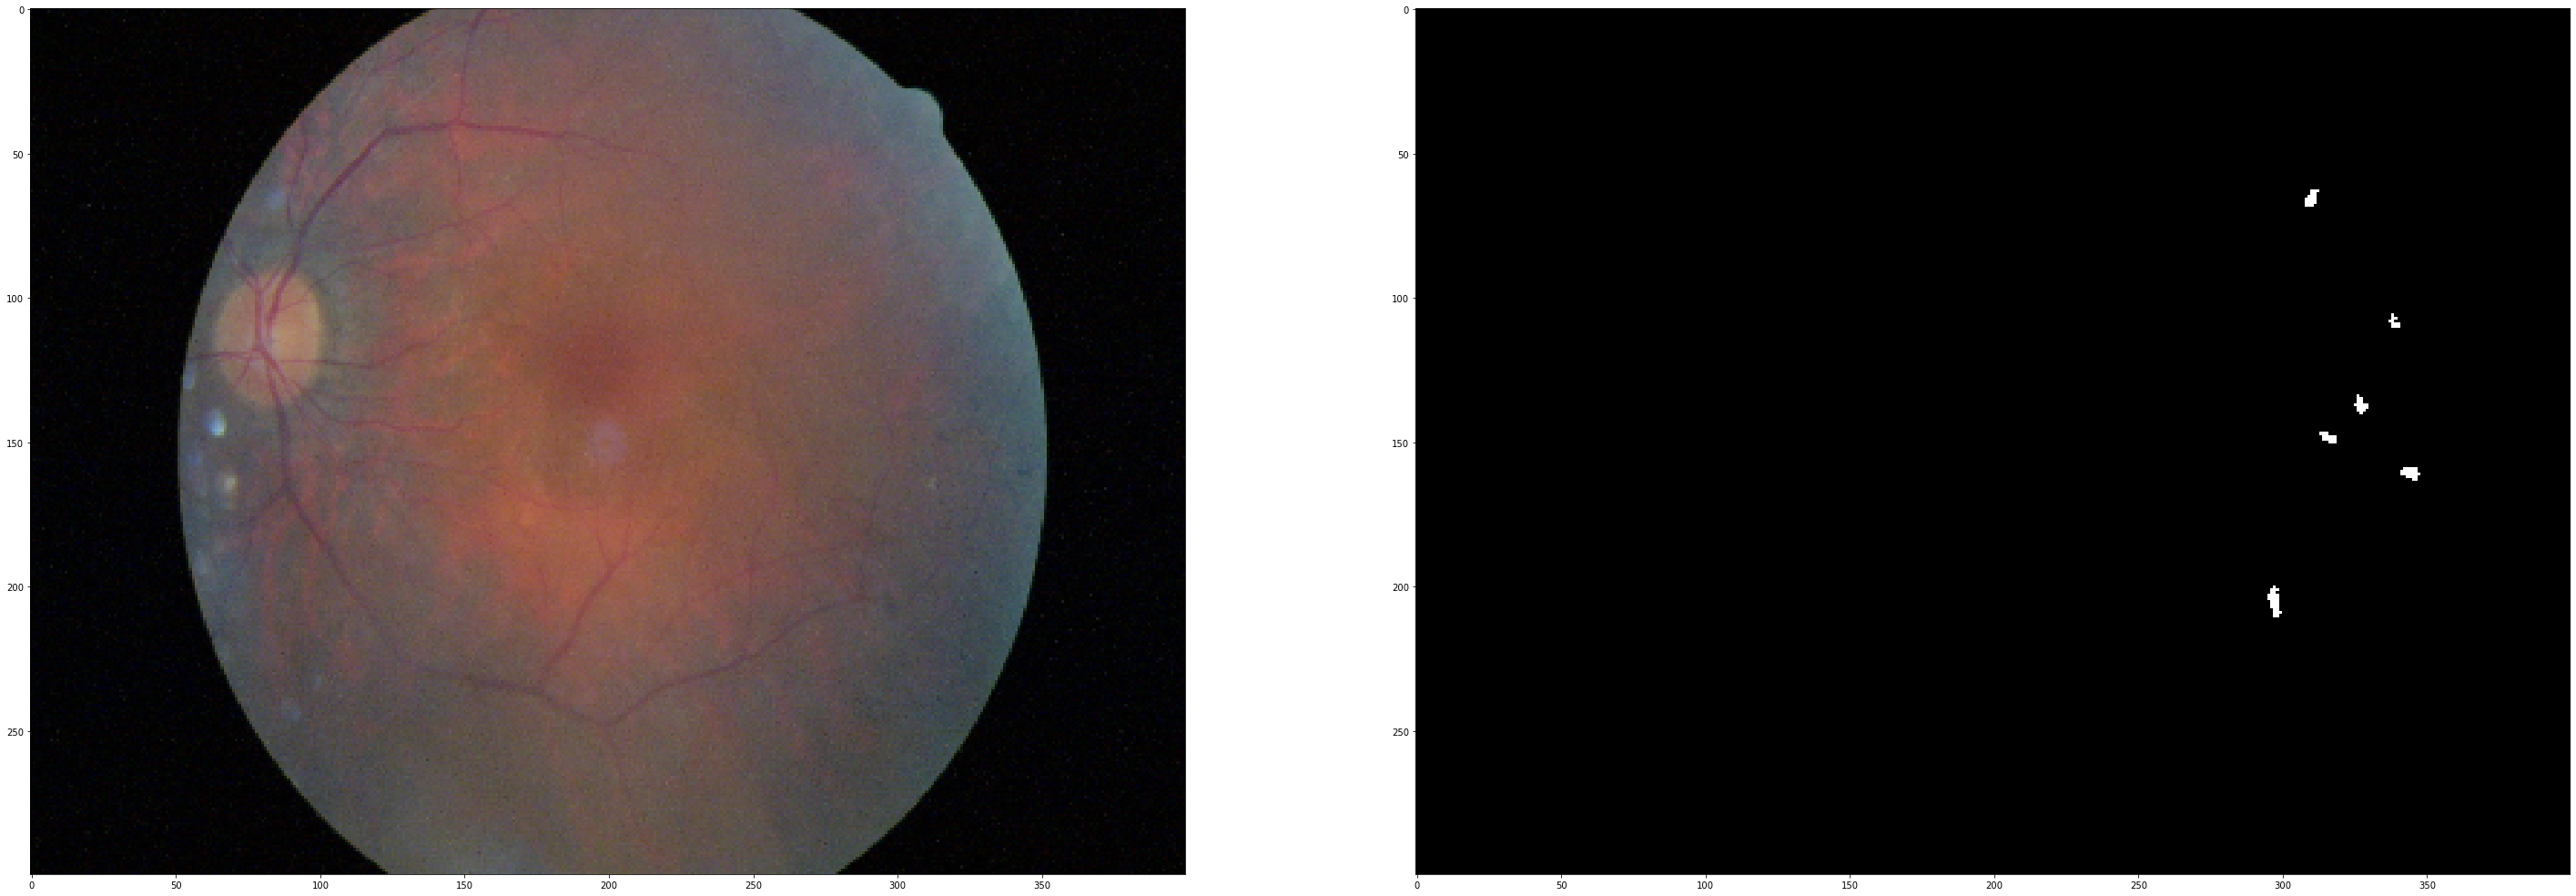

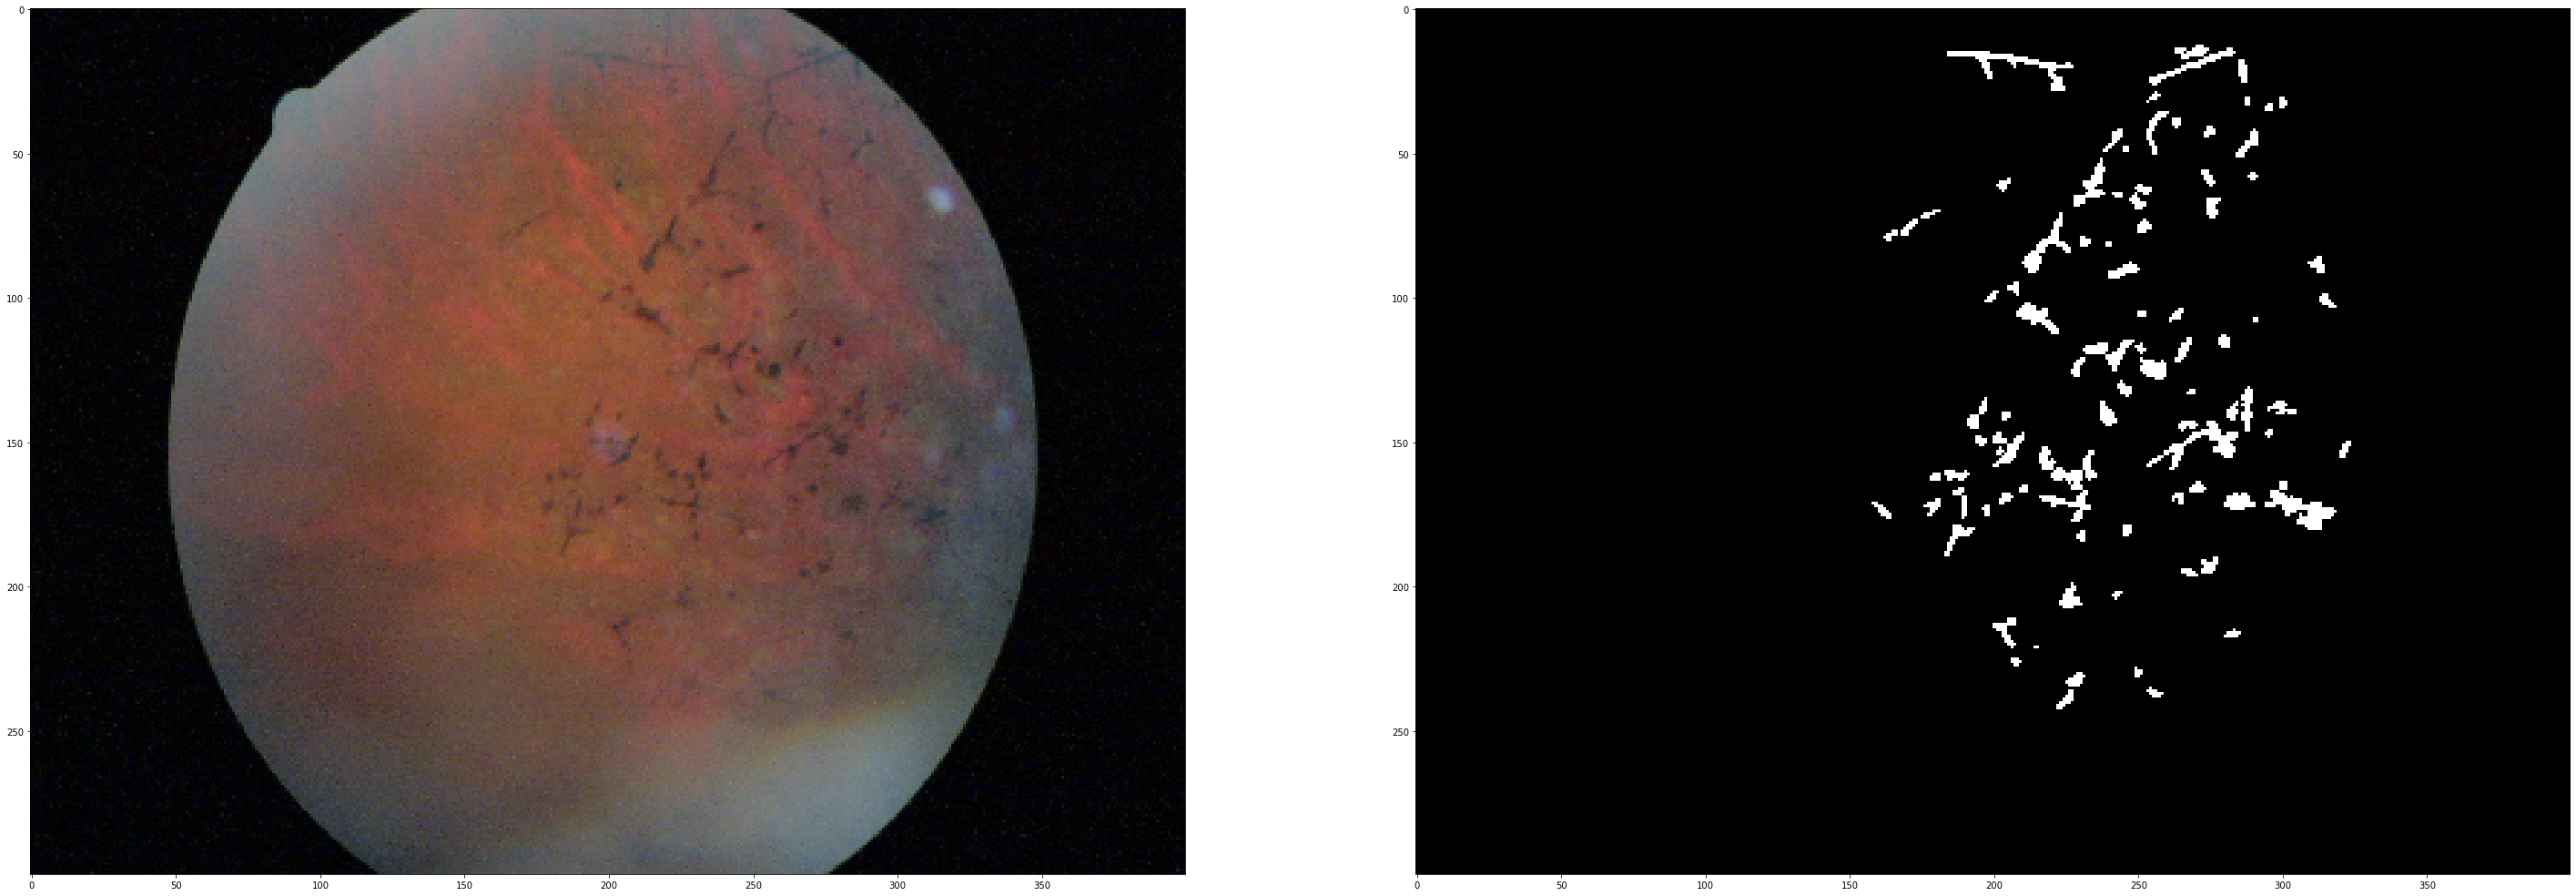

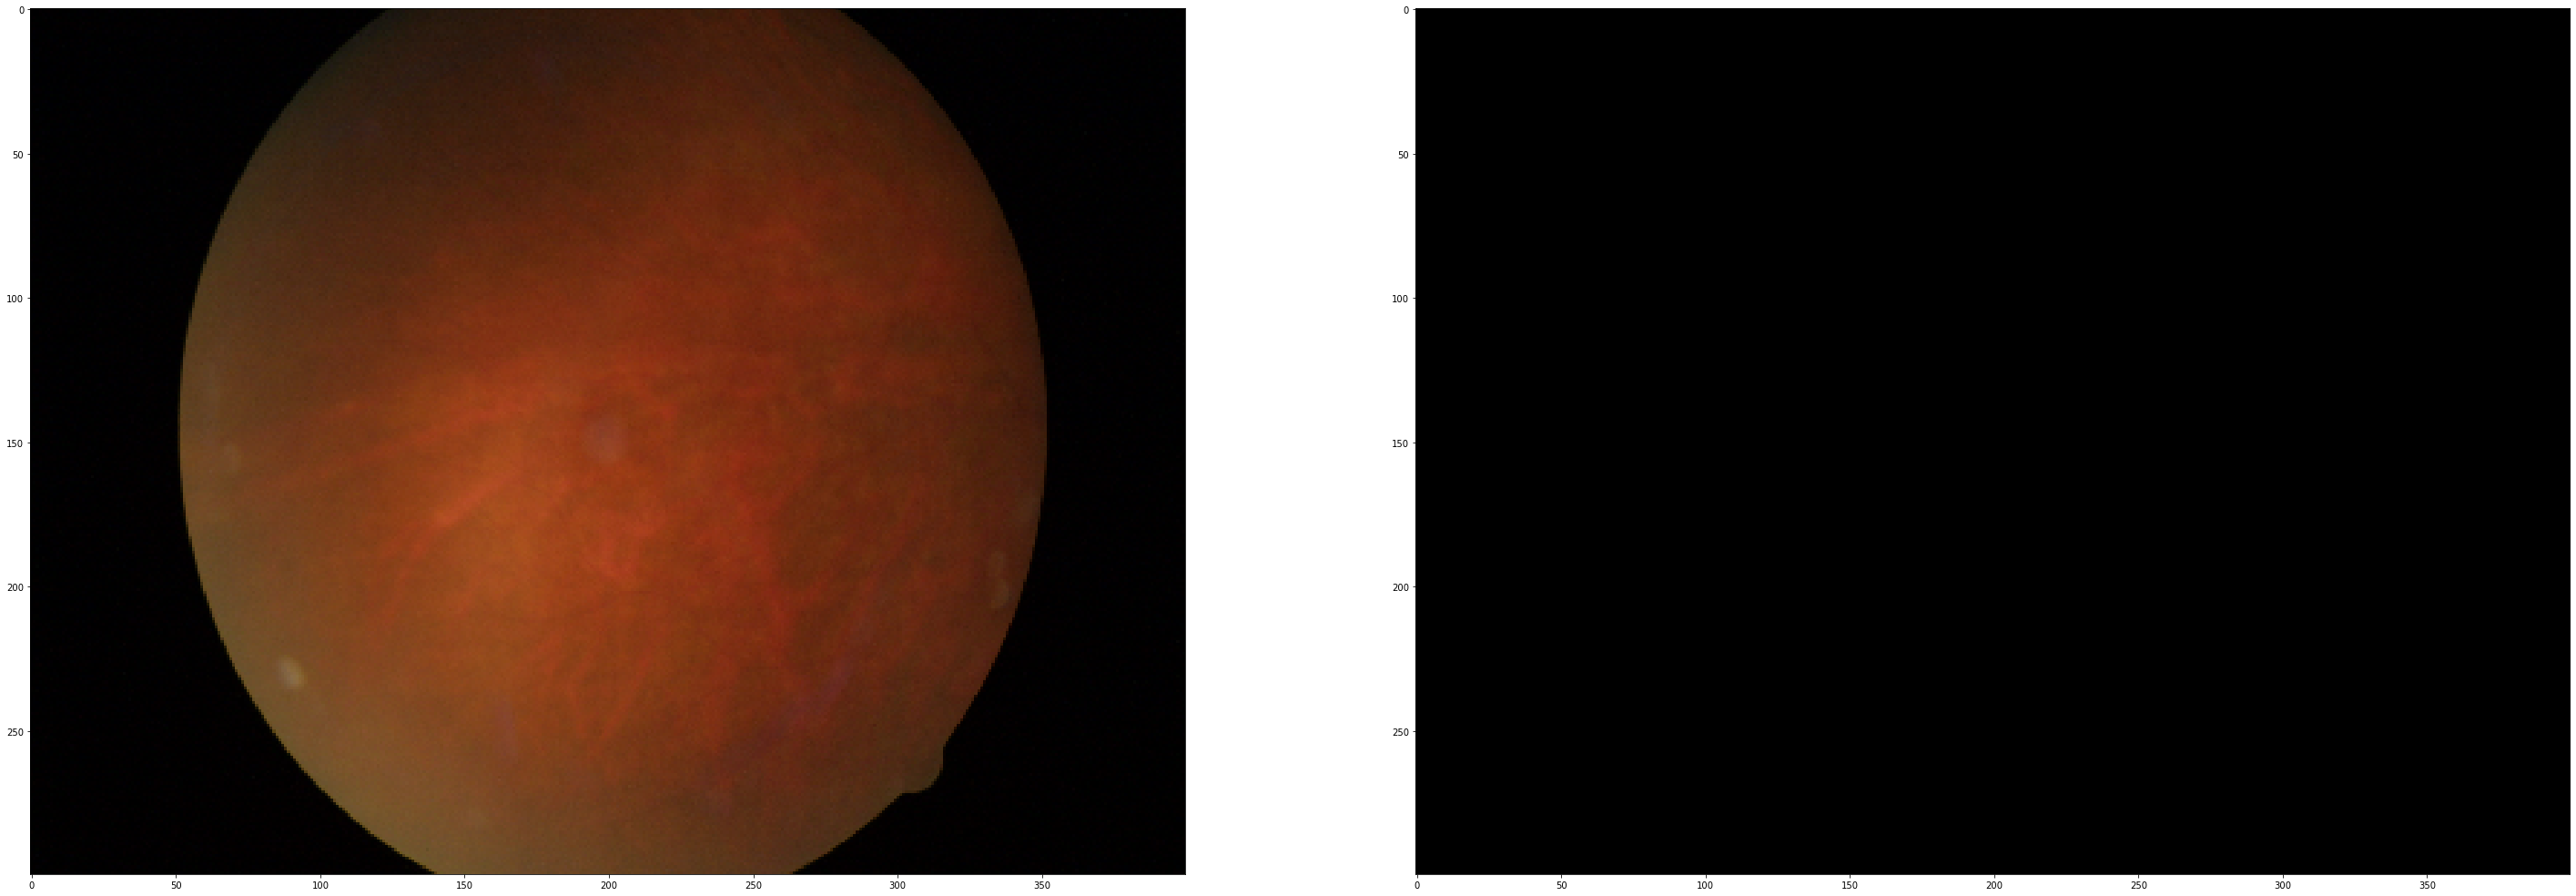

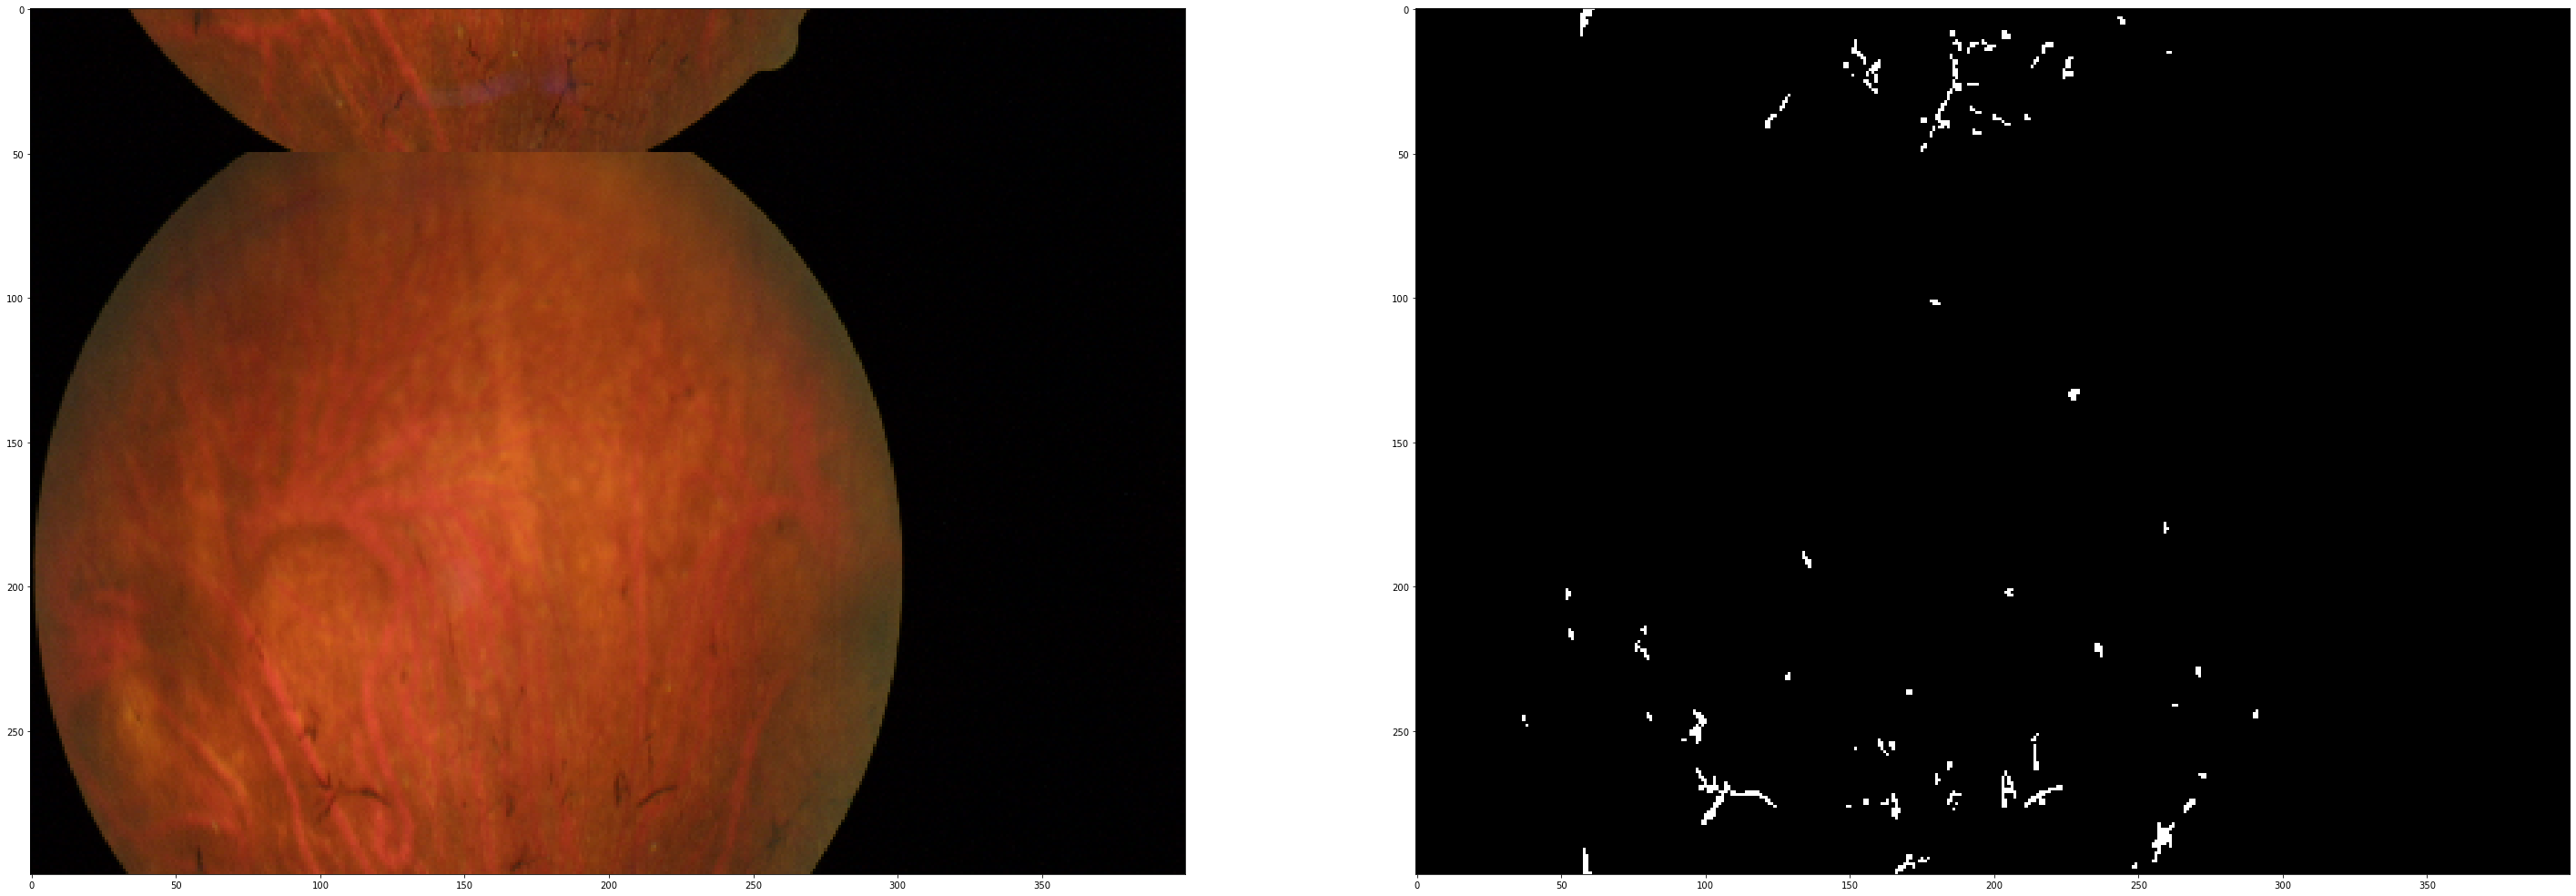

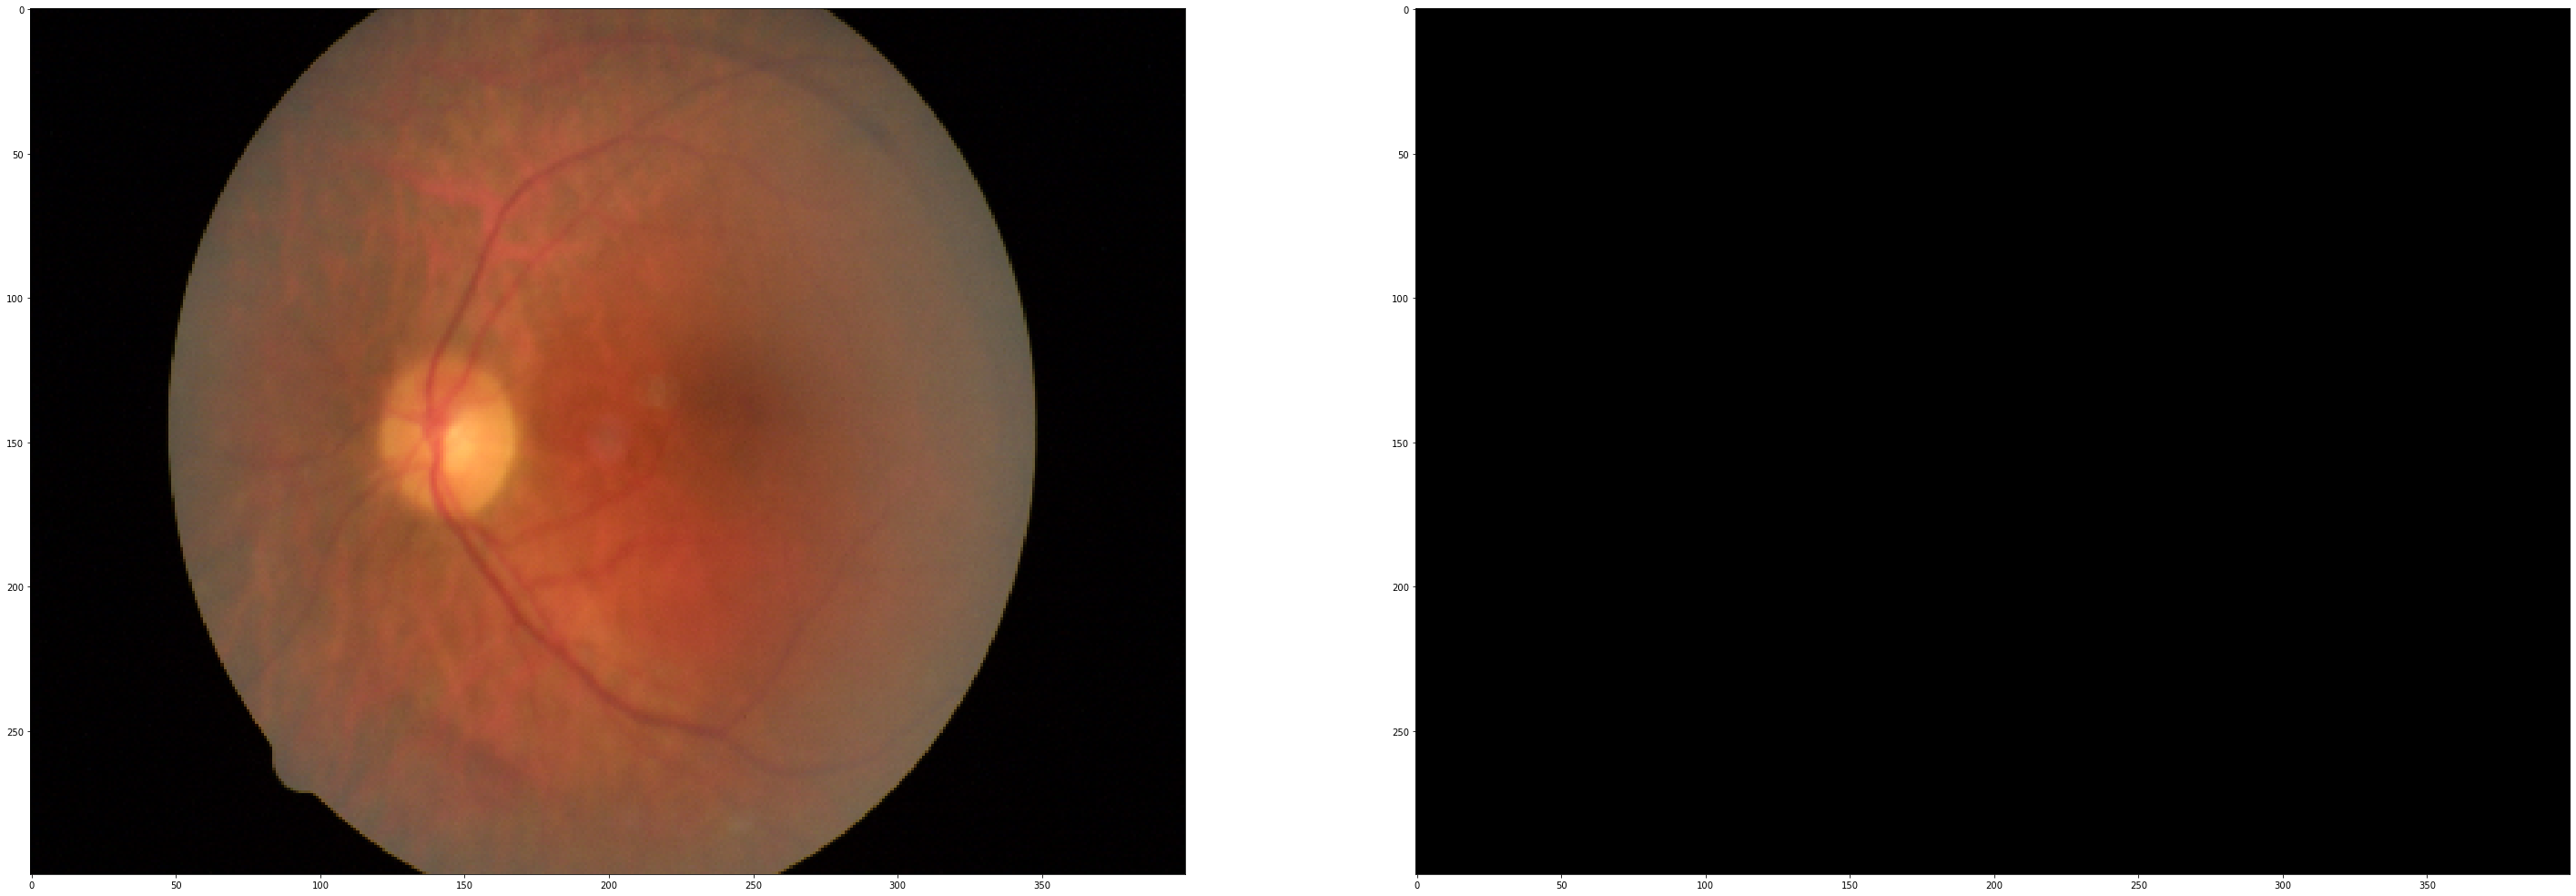

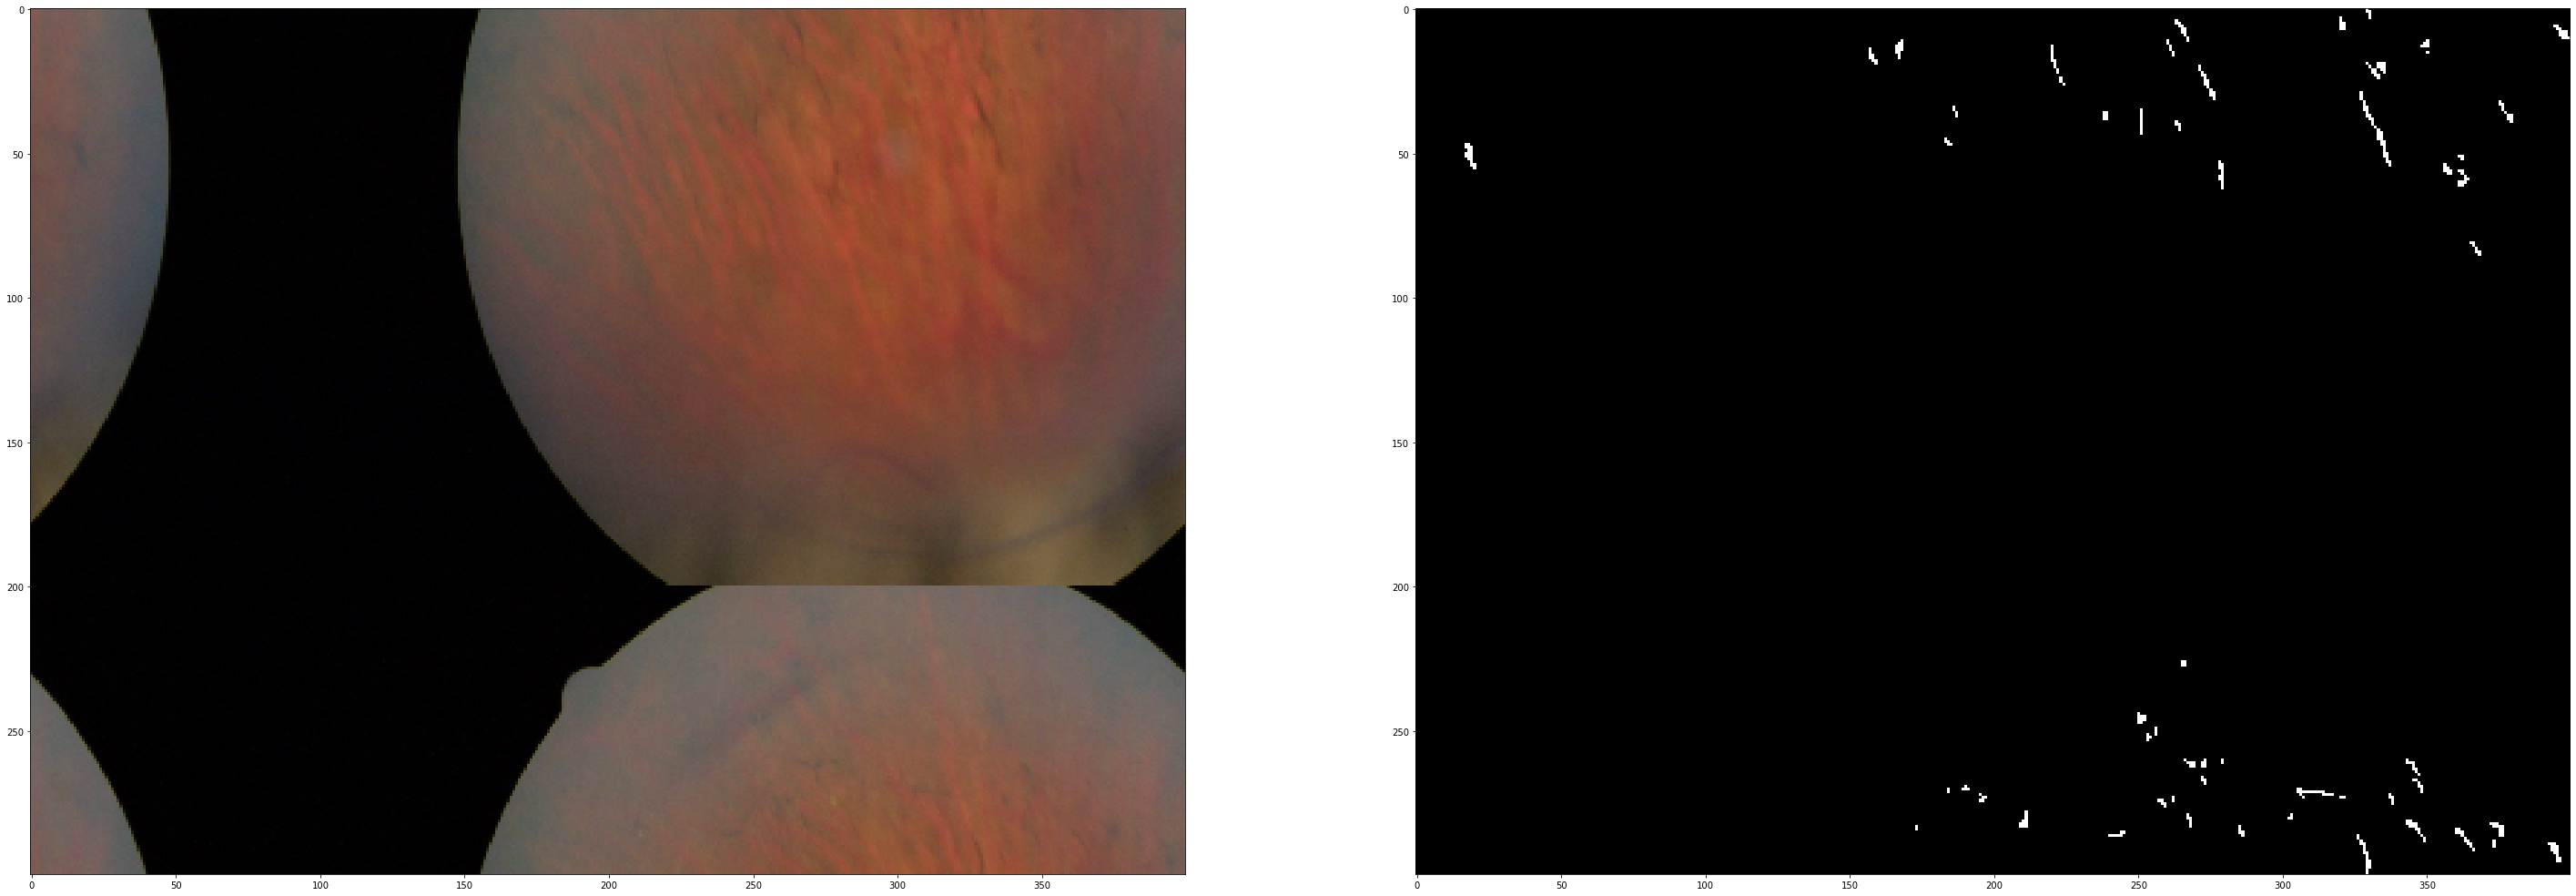

In [12]:
# checking augmentation done correctly, 6 diff augmentations for the same image
visualize(X_train[0,:,:,:], Y_train[0,:,:])
visualize(X_train[90,:,:,:], Y_train[90,:,:])
visualize(X_train[260,:,:,:], Y_train[260,:,:])
visualize(X_train[520,:,:,:], Y_train[520,:,:])
visualize(X_train[1040,:,:,:], Y_train[1040,:,:])
visualize(X_train[2080,:,:,:], Y_train[2080,:,:])

In [13]:
X_train = (X_train/255).astype('float32')  #division for normalizing, casting bec after division dtype will change from uint8 to float64, ie dataset size will inc by factor of *8 causing RAM to fill and session to crash 
Y_train = (Y_train/255).astype('uint8')
Images_test = (Images_test/255).astype('float32')
Masks_test = (Masks_test/255).astype('uint8')


In [14]:
X_validation = (X_validation/255).astype('float32') 
Y_validation = (Y_validation/255).astype('uint8')

In [15]:
print(Y_train.dtype)
print(X_train.dtype)

uint8
float32


In [16]:
print(np.unique(Y_train[500,:,:], return_counts=True))

(array([0, 1], dtype=uint8), array([119384,    616]))


In [17]:
# cv2.imshow('',X_train[2000,:,:,:]*255)  # NOTEEE the multiplication by 255
# cv2.imshow('',Y_train[2000,:,:]*255)
# cv2.imshow('',Images_test[3,:,:,:]*255)
# cv2.imshow('',Masks_test[3,:,:]*255)

In [18]:
np.save('Images_train_augmented.npy', X_train)
np.save('Masks_train_augmented.npy', Y_train)
np.save('Masks_test_processed.npy', Masks_test)
np.save('Images_test_processed.npy', Images_test)

In [19]:
# X_train = np.load('/content/drive/MyDrive/Images_train_augmented.npy')
# Y_train = np.load('/content/drive/MyDrive/Masks_train_augmented.npy')
# Images_test = np.load('/content/drive/MyDrive/Images_test_processed.npy')
# Masks_test = np.load('/content/drive/MyDrive/Masks_test_processed.npy')

SIDE NOTE: train and validation masks are 3D while test masks are 2D

## Addressing the class imbalance problem
**1) select the mask of any random image (flatten & scale)**

**2) generate a fully black image**

**3) calculate the loss between them.**

**4) as we can see loss is very small and very high accuracy (class imbalance)**

In [20]:
y_pred = np.zeros(Y_train[1000].shape)

print('accuracy_score=', accuracy_score(Y_train[1000],y_pred))
print('log_loss=', log_loss(Y_train[1000],y_pred))

accuracy_score= 0.26666666666666666
log_loss= 24.72477703106561


to solve this problem, instead of initilizing random weights for the model, we will generate 'weights' vector such that pixels the belongs to the foregroung would have high weight value while pixels that belongs to the BG would have small weight

Class Count [BG, pigment]:  [118615   1385]


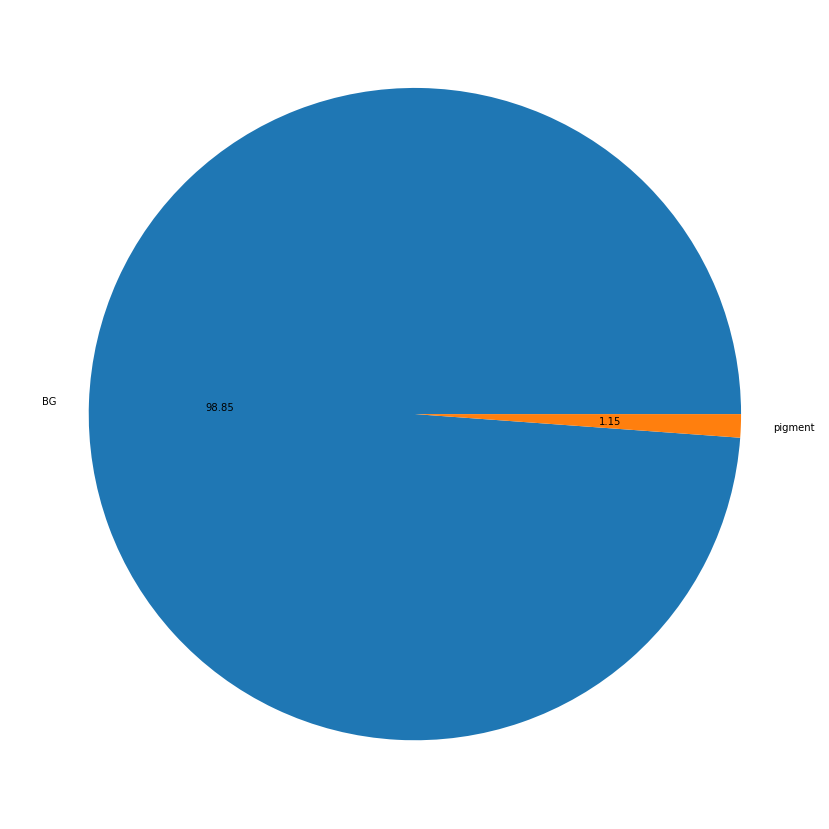

In [21]:
class_counts = np.unique(Y_train[50], return_counts = True)[1]
plt.figure(figsize=(15,15))
plt.pie(class_counts, labels=['BG','pigment'], autopct='%.2f')
print("Class Count [BG, pigment]: ", class_counts)

In [22]:
def RPS_encoder(x, nf):
    conv1 = Conv2D(nf,3, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(x)
    conv1_n = BatchNormalization()(conv1)
    conv1_n =activations.relu(conv1_n)
    conv2=Conv2D(nf,3, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(conv1_n)
    conc=Concatenate(axis=-1)([conv1,conv2])
    conv3=Conv2D(nf,1, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(conc)
    conv3= BatchNormalization()(conv3)
    conv3=activations.relu(conv3)
    out = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    return out,conv1;

def RPS_decoder(conv1_E,Eout, nf1, nf2, pad, final):
    up = Conv2DTranspose(nf1,2,(2,2),padding='same')(Eout)
    if pad:
        paddings = tf.constant([[0,0], [1,0],[0,0],[0,0]])
        up = tf.pad(up, paddings, "SYMMETRIC")
    conv1 = Conv2D(nf1,3, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(up)
    BN1 = BatchNormalization()(conv1)
    R1 = activations.relu(BN1)
    conv2 = Conv2D(nf2,3, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(R1)
    Conc=Concatenate(axis=-1)([conv2,conv1,conv1_E])
    conv3=Conv2D(nf2,1, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(Conc)
    BN2= BatchNormalization()(conv3)
    if final:                        
        D_out=activations.sigmoid(BN2)
    else:
        D_out=activations.relu(BN2)
    return D_out;

def RPS_Net():
    inputs = Input((300,400,3))
    out1,c1=RPS_encoder(inputs,64)
    out2,c2=RPS_encoder(out1,128)
    out3,c3=RPS_encoder(out2,256)
    out4,c4=RPS_encoder(out3,512)

    d1 = RPS_decoder(c4, out4, 512, 256,True, False)
    d2 = RPS_decoder(c3, d1, 256, 128,True, False)
    d3 = RPS_decoder(c2, d2, 128, 64, False, False)
    d4 = RPS_decoder(c1, d3, 64, 1, False, True)  

    model = Model(inputs=inputs, outputs=d4)
    return model

In [23]:
RPS = RPS_Net()
RPS.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 400, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 300, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 300, 400, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon =0.000001)
RPS.compile(optimizer=opt,loss= 'binary_crossentropy', metrics=['Recall','Precision','AUC', 'accuracy'])
model_history = RPS.fit(X_train, Y_train, batch_size = 10, epochs=20, shuffle = True)

Epoch 1/20
209/209 [==============================] - 236s 1s/step - loss: 0.6436 - recall: 0.4059 - precision: 0.0471 - auc: 0.8315 - accuracy: 0.9356
Epoch 2/20
209/209 [==============================] - 222s 1s/step - loss: 0.5443 - recall: 0.7736 - precision: 0.2480 - auc: 0.9272 - accuracy: 0.9812
Epoch 3/20
209/209 [==============================] - 223s 1s/step - loss: 0.4618 - recall: 0.7652 - precision: 0.4791 - auc: 0.9441 - accuracy: 0.9922
Epoch 4/20
209/209 [==============================] - 224s 1s/step - loss: 0.3968 - recall: 0.7637 - precision: 0.5728 - auc: 0.9556 - accuracy: 0.9941
Epoch 5/20
209/209 [==============================] - 223s 1s/step - loss: 0.3446 - recall: 0.7423 - precision: 0.6064 - auc: 0.9568 - accuracy: 0.9946
Epoch 6/20
209/209 [==============================] - 224s 1s/step - loss: 0.2984 - recall: 0.7365 - precision: 0.6629 - auc: 0.9696 - accuracy: 0.9953
Epoch 7/20
209/209 [==============================] - 223s 1s/step - loss: 0.2602 - reca

In [25]:
RPS.save('Fold3_model.h5')

In [26]:
RPS.save_weights('Fold3_weights.h5')

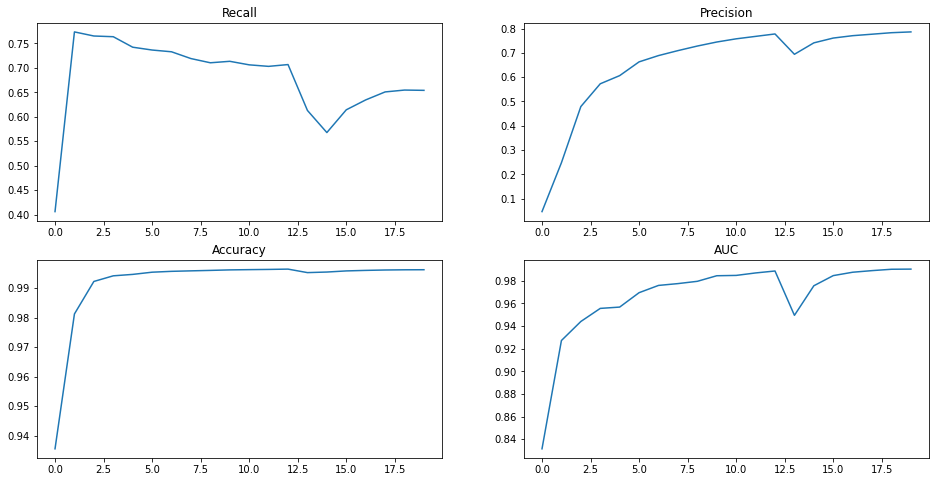

In [27]:
plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.title('Recall')
plt.plot(model_history.history["recall"]) 

plt.subplot(222)
plt.title('Precision')
plt.plot(model_history.history["precision"])

plt.subplot(223)
plt.title('Accuracy')
plt.plot(model_history.history["accuracy"])

plt.subplot(224)
plt.title('AUC')
plt.plot(model_history.history["auc"])

plt.show()

**TRAINING**

In [33]:
score = RPS.evaluate(X_train, Y_train, verbose=0)
print('training loss:', score[0])
print('training recall:', score[1])
print('training precision:', score[2])
print('training AUC:', score[3])
print('training accuracy:', score[4])

training loss: 0.06225813180208206
training recall: 0.5977292060852051
training precision: 0.8520321249961853
training AUC: 0.9940050840377808
training accuracy: 0.996300458908081


**VALIDATION**

In [28]:
score = RPS.evaluate(X_validation, Y_validation, verbose=0)
print('validation loss:', score[0])
print('validation recall:', score[1])
print('validation precision:', score[2])
print('validation AUC:', score[3])
print('validation accuracy:', score[4])

validation loss: 0.05727914720773697
validation recall: 0.611339807510376
validation precision: 0.794752299785614
validation AUC: 0.9941402077674866
validation accuracy: 0.9988172650337219


In [29]:
pred_masks = RPS.predict(X_validation)
pred_masks = (pred_masks >= 0.5)*1

In [30]:
# Flatten the predicted and true labels into 1D arrays
pred_masks_flat = pred_masks.flatten()
Y_validation_flat = Y_validation.flatten()

# Compute the confusion matrix and classification report
tn = np.sum(np.logical_and(pred_masks_flat == 0, Y_validation_flat == 0))
fp = np.sum(np.logical_and(pred_masks_flat == 1, Y_validation_flat == 0))
fn = np.sum(np.logical_and(pred_masks_flat == 0, Y_validation_flat == 1))
tp = np.sum(np.logical_and(pred_masks_flat == 1, Y_validation_flat == 1))

confusion_matrix = np.array([[tn, fp], [fn, tp]])

print("Confusion matrix:\n", confusion_matrix)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = (2*tp) / (2*tp+fp+fn)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1-score:", f1_score)

Confusion matrix:
 [[3471280    1189]
 [   2927    4604]]
Accuracy: 0.9988172413793104
Precision: 0.7947522872432246
Recall (Sensitivity): 0.6113397955118842
Specificity: 0.9996575923355975
F1-score: 0.6910837586310418


**TESTING**

(array([0]), array([120000]))
(array([0], dtype=uint8), array([120000]))
(array([0, 1]), array([118629,   1371]))
(array([0, 1], dtype=uint8), array([117867,   2133]))
(array([0, 1]), array([119412,    588]))
(array([0, 1], dtype=uint8), array([119259,    741]))
(array([0, 1]), array([119838,    162]))
(array([0, 1], dtype=uint8), array([119751,    249]))


<Figure size 432x288 with 0 Axes>

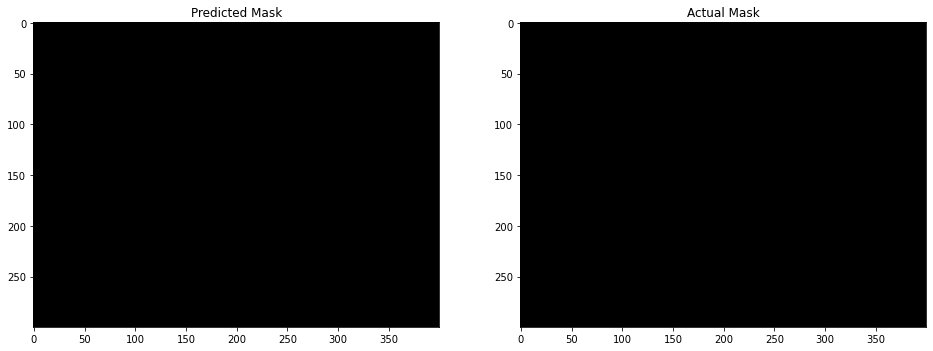

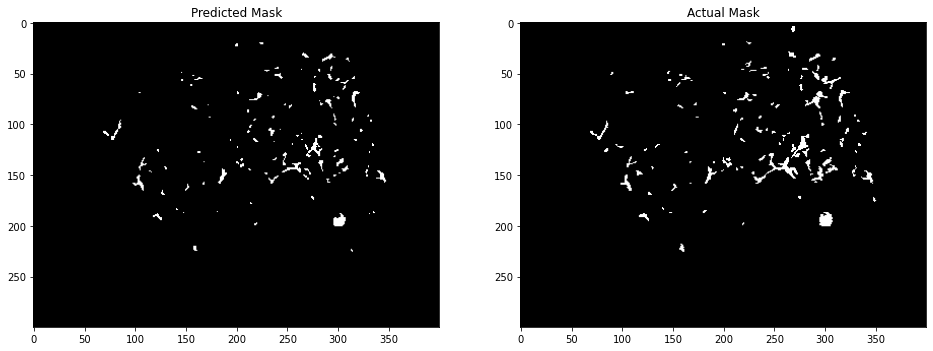

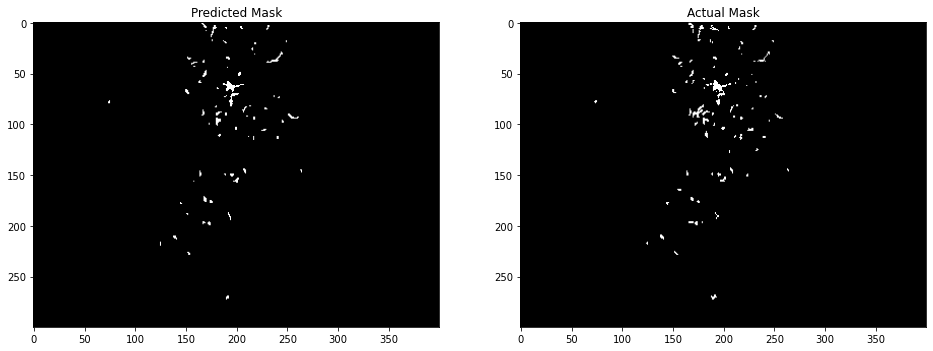

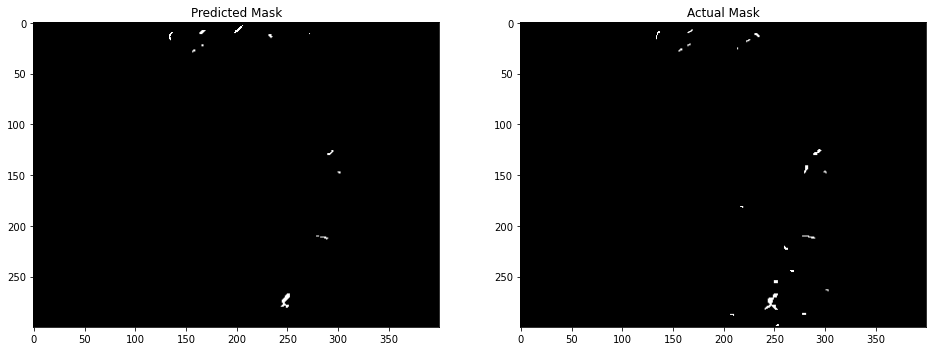

In [31]:
for i in range(Images_test.shape[0]):
    pred_mask = RPS.predict(Images_test[i,:,:,:].reshape(1, 300, 400, 3))
    pred_mask = (pred_mask >= 0.5)*1
    print(np.unique(pred_mask, return_counts=True))
    print(np.unique(Masks_test[i,:,:], return_counts=True))
    plt.gray()
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(pred_mask.reshape(300,400))
    ax[0].set_title('Predicted Mask')
    ax[1].imshow(Masks_test[i, :, :])
    ax[1].set_title('Actual Mask')

In [32]:
score = RPS.evaluate(Images_test, Masks_test, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])
print('Test precision:', score[2])
print('Test AUC:', score[3])
print('Test accuracy:', score[4])

Test loss: 0.061889197677373886
Test recall: 0.5699647665023804
Test precision: 0.8392267823219299
Test AUC: 0.9948515892028809
Test accuracy: 0.9964916706085205
